In [12]:
import numpy as np

import h5py
import glob
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import pickle

import math

In [3]:
data_dir='/root/autodl-tmp/interaction/dataset/MS-data/Roundabout/train_dataset.hdf5'
map_dir='/root/autodl-tmp/interaction/dataset/MS-data/Roundabout/maps/*.osm'

In [4]:
with open('roads.pkl', 'rb') as f:
    map = pickle.load(f) # 从文件f中读取d

In [5]:
def split_input_output_normalize( agents_data, meta_data, agent_types):

    in_horizon = 5
    num_others = 8

    agent_masks = np.expand_dims(agents_data[:, :, 0] != -1, axis=-1).astype(np.float32)  # existence mask
    agents_data[:, :, :2] -= np.array([[meta_data[0], meta_data[1]]])  # Normalize with translation only  from xmin, ymin
    agents_data = np.nan_to_num(agents_data, nan=-1.0)  # pedestrians have nans instead of yaw and size
    agents_data = np.concatenate([agents_data, agent_masks], axis=-1)

    dists = euclidean_distances(agents_data[:, in_horizon - 1, :2], agents_data[:, in_horizon - 1, :2])
    agent_masks[agent_masks == 0] = np.nan
    dists *= agent_masks[:, in_horizon - 1]
    dists *= agent_masks[:, in_horizon - 1].transpose()
    ego_idx = np.random.randint(0, int(np.nansum(agent_masks[:, in_horizon - 1])))
    closest_agents = np.argsort(dists[ego_idx])
    agents_data = agents_data[closest_agents[:num_others + 1]]
    agent_types = agent_types[closest_agents[:num_others + 1]]

    agents_in = agents_data[1:(num_others + 1), :in_horizon]
    agents_out = agents_data[1:(num_others + 1), in_horizon:, [0, 1, 4, 7]]  # returning positions and yaws
    ego_in = agents_data[0, :in_horizon]
    ego_out = agents_data[0, in_horizon:]
    ego_out = ego_out[:, [0, 1, 4, 7]]  # returning positions and yaws

    return ego_in, ego_out, agents_in, agents_out, agent_types

def copy_agent_roads_across_agents( agents_in, roads):
    num_others = 8
    
    new_roads = np.zeros((num_others + 1, *roads.shape))
    new_roads[0] = roads  # ego
    for n in range(num_others):
        if agents_in[n, -1, -1]:
            new_roads[n + 1] = roads
    return new_roads

In [6]:
map.keys()

dict_keys(['DR_USA_Roundabout_SR.osm', 'DR_CHN_Merging_ZS0.osm', 'DR_Merging_TR0.osm', 'DR_CHN_Merging_ZS2.osm', 'DR_USA_Roundabout_EP.osm', 'DR_CHN_Roundabout_LN.osm', 'DR_Merging_TR1.osm', 'DR_USA_Roundabout_FT.osm', 'DR_DEU_Roundabout_OF.osm', 'DR_DEU_Merging_MT.osm', 'DR_Roundabout_RW.osm', 'DR_USA_Intersection_EP0.osm', 'DR_USA_Intersection_GL.osm', 'DR_LaneChange_ET1.osm', 'DR_Intersection_CM.osm', 'DR_LaneChange_ET0.osm', 'DR_USA_Intersection_MA.osm', 'DR_USA_Intersection_EP1.osm'])

In [21]:
def _plot_debug(ego_in, ego_out, agents_in, agents_out, roads,idx):
    num_others = 8
    for n in range(num_others + 1):
        plt.figure()
        if n == 0:
            plt.scatter(ego_in[:, 0], ego_in[:, 1], color='k')
            plt.scatter(ego_out[:, 0], ego_out[:, 1], color='m')
        else:
            if agents_in[n - 1, -1, -1]:
                plt.scatter(agents_in[n - 1, :, 0], agents_in[n - 1, :, 1], color='k')
                plt.scatter(agents_out[n - 1, :, 0], agents_out[n - 1, :, 1], color='m')
        for s in range(roads.shape[1]):
            for p in range(roads.shape[2]):
                if roads[n, s, p, -1]:
                    plt.scatter(roads[n, s, p, 0], roads[n, s, p, 1], color='g',s=1)
        
        
        plt.show()
        # plt.savefig(f"pics/{n}_{idx}.png")
        # if n>1:
        break

In [9]:
def rotate_pc(pc, alpha):
    M = np.array([[np.cos(alpha), -np.sin(alpha)],
                [np.sin(alpha), np.cos(alpha)]])
    if len(pc.shape)==3:
        return (M @ pc.swapaxes(1,2)).swapaxes(1,2)
    else:
        return (M @ pc.T).T

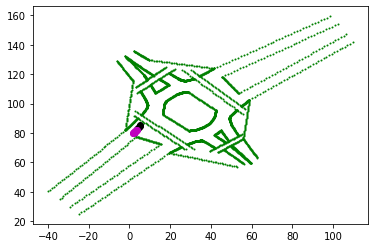

In [52]:
idx=0
max_num_road_segs = 78

if self.augment_data:
    rand_angle = np.random.uniform(-180, 180) # 生成一个-180到180之间的随机数
    rand_angle = np.round(rand_angle / 15) * 15 # 对其除以15并四舍五入，再乘以15

    angle=math.radians(rand_angle)

dataset = h5py.File(data_dir, 'r')
agents_data = dataset['agents_trajectories'][idx]  #'x', 'y', 'vx', 'vy', 'psi_rad', 'length', 'width'        
agent_types = dataset['agents_types'][idx]
meta_data = dataset['metas'][idx]

if self.augment_data:
    agents_data[:,:,4]=(agents_data[:,:,4]+angle) #左乘旋转矩阵相当于逆时针旋转，

    psi_rad=agents_data[:,:,4]
    psi_rad=np.where(psi_rad>np.pi,psi_rad-2*np.pi,psi_rad)
    psi_rad=np.where(psi_rad<-np.pi,psi_rad+2*np.pi,psi_rad)
    agents_data[:,:,4]=psi_rad

agents_data = agents_data[:, 1::2]

road_fname_key = dataset['map_paths'][idx][0].decode("utf-8").split("/")[-1]
roads = map[road_fname_key].copy()


# meta_data[:2]=rotate_pc(meta_data[:2],angle)


roads[:, :, :2] -= np.expand_dims(np.array([meta_data[:2]]), 0)  # 把map转到局部坐标

original_roads = np.zeros((max_num_road_segs, *roads.shape[1:]))
original_roads[:len(roads)] = roads
roads = original_roads.copy()

#ego_in output : 'x', 'y', 'vx', 'vy', 'psi_rad', 'length', 'width' 'mask'
np.random.seed(1)
ego_in, ego_out, agents_in, agents_out, agent_types = split_input_output_normalize(agents_data, meta_data,
                                                                                        agent_types)
if self.augment_data:
    ego_in[:,:2]=rotate_pc(ego_in[:,:2],angle)
    ego_in[:,2:4]=rotate_pc(ego_in[:,2:4],angle)


    ego_out[:,:2]=rotate_pc(ego_out[:,:2],angle)

    agents_in[:,:,:2]=rotate_pc(agents_in[:,:,:2],angle)
    agents_in[:,:,2:4]=rotate_pc(agents_in[:,:,2:4],angle)

    agents_out[:,:,:2]=rotate_pc(agents_out[:,:,:2],angle)

    roads[:, :, :2]=rotate_pc(roads[:, :, :2],angle)

roads = copy_agent_roads_across_agents(agents_in, roads)


_plot_debug(ego_in, ego_out, agents_in, agents_out, roads,idx)

In [56]:
math.degrees(angle)

44.74663298449818

In [57]:
math.degrees(ego_in[:,4][-1])


-120.32251121153388

In [53]:
ego_in[:,4]

array([-2.086024 , -2.088024 , -2.0920238, -2.096024 , -2.100024 ],
      dtype=float32)

In [26]:
agents_data.shape

(50, 20, 7)

In [31]:
np.nanmax(agents_data[:,:,4])

2.989

In [32]:
np.nanmin(agents_data[:,:,4])


-3.047

In [35]:
agents_data[2,0,4]

-3.045

In [36]:
np.arctan2(agents_data[2,0,2],agents_data[2,0,3])

0.0

In [48]:
psi_rad=agents_data[:,:,4]

psi_rad=np.where(psi_rad>np.pi,psi_rad-2*np.pi,psi_rad)
psi_rad=np.where(psi_rad<-np.pi,psi_rad+2*np.pi,psi_rad)

agents_data[:,:,4]=psi_rad
# agents_data[:,:,4]=(agents_data[:,:,4]+angle) #左乘旋转矩阵相当于逆时针旋转，
# agents_data[:,:,4]=agents_data[agents_data[:,:,4]>np.pi]-2*np.pi  #重新换算到-pi~pi
# agents_data[:,:,4]=agents_data[agents_data[:,:,4]<-np.pi]+2*np.pi

In [49]:
psi_rad.shape

(50, 20)

In [50]:

psi_rad+=1

In [64]:
x = np.random.uniform(-180, 180) # 生成一个-180到180之间的随机数
x = np.round(x / 15) * 15

In [65]:
x

180.0